# Идентификация интернет-пользователей. Отчёт

In [ ]:
# !unzip capstone_user_identification.zip

## Содержание

1. [Цели и задачи проекта](#Цели-и-задачи-проекта)
2. [Постановка задачи](#Постановка-задачи)
2. описание исходных и обработанных данных и признаков.
2. первичный анализ признаков
3. первичный визуальный анализ признаков
4. если пришли к каким-то "инсайтам", обнаружили закономерности – изложите
5. описание предобработки данных
6. если создаются признаки, то описание этого процесса
7. кросс-валидация, построение кривых валидации и обучения
8. оценка модели с описанием выбранной метрики. Опишите простыми словами
9. качество модели, как она может применяться
10. выводы: как построенная модель может применяться на практике, какие бизнес-задачи решать. 
11. Подведите итог, опишите, что еще можно сделать, а что сделать не удалось.

## Цели и задачи проекта

Постулируем 2 основные цели проекта:
- учебная
- исследовательская

К учебной части отнесём закрепление теоретических знаний и отработка их на парктике, а именно.

К исследовательской части отнесём следующие задачи:
- постановка ML-задачи
- предобработка входных данных
- exploratory data analysis (визулизация)
- feature engineering
- подбор модели и её гиперпараметров
- проверка модели на кроссвалидации и отложенных выборках
- оценка применения модели к бизнес-задачам

## Описание проекта

В проекте ставится задача по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком идентифицировать этого человека. Идея в том что, пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

## Описание входных данных

Входные данные взяты из [статьи](http://ceur-ws.org/Vol-1703/paper12.pdf) "A Tool for Classification of Sequential Data".

Данные пришли с прокси-серверов Университета Блеза Паскаля и имеют следующий вид: для каждого пользователя заведен csv-файл с названием user****.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в двух колонках: _timestamp, site_

Данные устроены следующем образом:

- каталог 3users – пример из 3 файлов для отладки кода предобработки
- в каталог 10users лежат 10 csv-файлов с названием вида "user[USER_ID].csv", где [USER_ID] – ID пользователя
- аналогично для каталога 150users – 150 пользователей

In [1]:
import os
import pandas as pd

PATH_TO_DATA = 'data'

Посмотрим на данные.

Пользователь 0001 из каталога с 3 пользователями:

In [4]:
pd.read_csv(os.path.join(PATH_TO_DATA, '3users/user0001.csv'))

,timestamp,site
0,2013-11-15 09:28:17,vk.com
1,2013-11-15 09:33:04,oracle.com
2,2013-11-15 09:52:48,oracle.com
3,2013-11-15 11:37:26,geo.mozilla.org
4,2013-11-15 11:40:32,oracle.com
5,2013-11-15 11:40:34,google.com
6,2013-11-15 11:40:35,accounts.google.com
7,2013-11-15 11:40:37,mail.google.com
8,2013-11-15 11:40:40,apis.google.com
9,2013-11-15 11:41:35,plus.google.com


Пользователь 0031 из каталога с 10 пользователями:

In [5]:
pd.read_csv(os.path.join(PATH_TO_DATA, '10users/user0031.csv'))

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net
...,...,...
7595,2014-03-28 13:09:06,webmail.laposte.net
7596,2014-03-28 13:09:07,av.mediapostcommunication.net
7597,2014-03-28 13:09:07,www.google.com
7598,2014-03-28 13:09:07,webmail.laposte.net


Пользователь 0006 из каталога с 150 пользователями:

In [6]:
pd.read_csv(os.path.join(PATH_TO_DATA, '150users/user0006.csv'))

,timestamp,site
0,2013-11-15 08:01:09,www.google.fr
1,2013-11-15 08:01:10,www.google.fr
2,2013-11-15 08:01:11,apis.google.com
3,2013-11-15 08:01:12,www.google.com
4,2013-11-15 08:01:16,www.google.fr
...,...,...
21360,2014-05-28 19:10:00,www.facebook.com
21361,2014-05-28 19:10:01,i3.mangareader.net
21362,2014-05-28 19:10:14,www.mangareader.net
21363,2014-05-28 19:10:15,www.facebook.com


## Постановка задачи

Для достижения целей проекта поставим ML-задачу: 
- классификация
- объект: сессия
- целевой признак: id пользователя

Сессия - последовательность n-посещенных сайтов. Размер сессий определяется:
- количеством сайтом
- временем от первого сайта в сессии

Таким образом требуется преобразовать входные данные в вид:

|site1|timestamp1|site2|timestamp2|...|site_n|timestamp_n|user_id|
|---|---|---|---|---|---|---|---|

То есть для каждого пользователя его история посещения разбивается на окна размера $n$ с шагом $m$ ($n$ и $m$ - параметры)

Возможны варианты классификации:
- многоклассовая (целевой признак user_id)
- бинарная классификация (один из пользователей объявляется искомым; для этого пользователя целевой признак принимает значение True, для остальных - False)

## Подготовка обучающей выборки

In [9]:
import itertools
from itertools import islice
from itertools import tee

from glob import glob
import pickle
import numpy as np
import pandas as pd
import os

from scipy.sparse import csr_matrix

from tqdm.notebook import tqdm

PATH_TO_DATA = 'data'

Создадим словари сайтов в формате:

`{'site_string': [site_id, site_freq]}`

Разобьём данные по сессиям с параметром длины сессии (10 сайтов)

In [4]:
def prepare_train_set(path_to_csv_files, session_length=10):
    site_dict = {} # словарь для задания
    site_map = {0: 0} # удобный словарь для маппинга сайтов в айдишники
    train_set = []
    user_ids = [] # user_id сохраняем в отдельный список, потом удобно его вставить в датафрейм
    site_id = 1
    for file in tqdm(glob(path_to_csv_files + '/*')):
        user_id = int(os.path.splitext(os.path.basename(file))[0][-4:])
        with open(file) as reader:
            reader.readline() # пропускаем первую строку
            # читаем батчами по session_length строк
            for batch in iter(lambda: tuple(islice(reader, session_length)), ()):
                sites = list(map(lambda x: x.split(',')[1].strip(), batch))
                # обновляем словари
                for site in sites:
                    if site not in site_dict:
                        site_map[site] = site_id
                        site_dict[site] = (site_id, 1)
                        site_id += 1
                    else:
                        t = site_dict[site]
                        site_dict[site] = (t[0], t[1] + 1)
                user_ids.append(user_id)
                train_set.append(sites)
    train_set = pd.DataFrame(train_set, columns=[f'site{i+1}' for i in range(session_length)]).fillna(0)
    train_set = train_set.applymap(lambda x: site_map[x] if type(x)==str else x)
    train_set['user_id'] = user_ids
    return train_set, site_dict

In [10]:
%%time
train_data_toy, site_freq_3users = prepare_train_set(os.path.join(PATH_TO_DATA, '3users'))
train_data_10users, site_freq_10users = prepare_train_set(os.path.join(PATH_TO_DATA, '10users'))
train_data_150users, site_freq_150users = prepare_train_set(os.path.join(PATH_TO_DATA, '150users'))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

CPU times: user 4.23 s, sys: 176 ms, total: 4.41 s
Wall time: 4.45 s


In [11]:
site_freq_3users

{'accounts.google.com': (5, 1),
 'apis.google.com': (7, 1),
 'football.kulichki.ru': (9, 2),
 'geo.mozilla.org': (3, 1),
 'google.com': (4, 9),
 'mail.google.com': (6, 2),
 'meduza.io': (10, 3),
 'oracle.com': (2, 8),
 'plus.google.com': (8, 1),
 'vk.com': (1, 3),
 'yandex.ru': (11, 1)}

In [12]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
0,1,2,2,3,2,4,5,6,7,8,1
1,1,4,4,4,0,0,0,0,0,0,1
2,1,2,9,9,2,0,0,0,0,0,2
3,10,4,2,4,2,4,4,6,11,10,3
4,10,4,2,0,0,0,0,0,0,0,3


Сохраним полученные датасеты в csv-формате,а словари в pickle-формате.

In [13]:
train_data_10users.to_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), index_label='session_id', float_format='%d')
train_data_150users.to_csv(os.path.join(PATH_TO_DATA, 'train_data_150users.csv'), index_label='session_id', float_format='%d')
with open(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_3users.pkl'), 'wb') as site_freq_3users_pkl:
    pickle.dump(site_freq_3users, site_freq_3users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_10users.pkl'), 'wb') as site_freq_10users_pkl:
    pickle.dump(site_freq_10users, site_freq_10users_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_150users.pkl'), 'wb') as site_freq_150users_pkl:
    pickle.dump(site_freq_150users, site_freq_150users_pkl, protocol=2)

Разобъём данные на сессии с использованием концепции "мешка слов". Размер сессии и шаг параметризируем.

"Мешок слов" - матрицы, в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки $i$ и столбца $j$ будет стоять число $n_{ij}$ – cколько раз сайт $j$ встретился в сессии номер $i$.

In [14]:
def get_session(session_it, session_length):
    '''
    Принимает итератор
    Возвращает список посещений заданной длины сессии
    '''
    try:
        for i in range(session_length):
            yield next(session_it)
    except StopIteration:
        return

In [15]:
def get_sites(file, session_length, window_size):
    '''
    Создаёт массив сессий пользователя
    session_length: длины сессии
    window_size: длина шага
    '''
    windows_it = iter(file) # итератор по всему файлу (по строкам)
    i = 0

    while True:
        try:
            if i % window_size == 0: # начинаем писать сессию
                # копируем итератор в новый; новый итератор только по сессии (как вложенный цикл)
                windows_it, session_it = tee(windows_it)
                session = list(get_session(session_it, session_length))
                if session:
                    yield list(map(lambda x: x.split(',')[1].strip(), session))
        except StopIteration:
            return

        try:
            next(windows_it)
            i += 1
        except StopIteration:
            return

In [16]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, session_length=10, window_size=10):
    '''
    Аргументы:
    path_to_csv_files: путь к каталогу с csv-файлами
    site_freq_path: путь к pickle-файлу с частотным словарем
    session_length: длина сессии (параметр)
    window_size: ширина окна (параметр)

    Возвращает:
    X_sparse: двухмерная разреженная матрица Scipy.sparse.csr_matrix, в которой строки соответствуют сессиям из session_length сайтов, 
    а max(site_id) столбцов – количеству посещений site_id в сессии
    y: целевой признак, вектор (Numpy array) ID пользователей, которым принадлежат сессии из X_sparse
    '''
    site_dict = []
    train_set, user_ids = [], []

    # скачиваем словарь сайтов    
    with open(site_freq_path, 'rb') as f:
        site_dict.append(pickle.load(f))
    site_map = {k: v[0] for k, v in site_dict[0].items()}

    
    for file_ in tqdm(glob(os.path.join(path_to_csv_files, '*'))):
        user_id = int(os.path.splitext(os.path.basename(file_))[0][-4:])
        with open(file_) as f:
            f.readline() # пропускаем первую строку
            # итерируемся по сессиям одного пользователя
            for session in get_sites(f, session_length, window_size):
                train_set.append(session)
                user_ids.append(user_id)
                
    train_set = pd.DataFrame(train_set).fillna(0)
    train_set.columns = [f'site{i+1}' for i in range(train_set.columns.size)] # если максимальная длина сессии меньше session_length
    train_set = train_set.applymap(lambda x: site_map[x] if type(x)==str else x).values
    
    # создаём bag of sites
    data = [1] * train_set.size # массив единиц длины n*m - count'ы сайтов (с повторениями)
    indices = train_set.flatten() # массив индексов столбцоы, на которых размещаются единицы; по сути спрямлённый DataFrame индексов
    indptr = list(range(0, train_set.size + 1, session_length)) # массив отрезков длины сессии (в нашем случае просто отсечки по длинам строк)
    X_sparse = csr_matrix((data, indices, indptr))[:, 1:] # отрезаем столбец для сайта 0 (отсутствие посещения)

    return X_sparse, np.array(user_ids)

Для параметров возьмём значения:
- размер сессии: 5, 7, 10, 15
- размер шага окна: 5, 7, 10

Сохраним полученные csr-матрицы и векторы целевых признаков в сериализованном виде.

In [17]:
%%time
data_lengths = []

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, f'{num_users}users'), 
                                                          os.path.join(PATH_TO_DATA, 'site_freqs', f'site_freq_{num_users}users.pkl'),
                                                          session_length=session_length, window_size=window_size)
            with open(os.path.join(PATH_TO_DATA, 'sparse_features', f'X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl'), 'wb')\
                                                                                                                as X_pkl:
                pickle.dump(X_sparse, X_pkl, protocol=2)
            with open(os.path.join(PATH_TO_DATA, 'sparse_features', f'y_{num_users}users_s{session_length}_w{window_size}.pkl'), 'wb') as y_pkl:
                pickle.dump(y, y_pkl, protocol=2)
            data_lengths.append(X_sparse.shape[0])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

CPU times: user 55.7 s, sys: 1.62 s, total: 57.3 s
Wall time: 57.6 s


## Exploratory Data Analysis

Исследуем данные, посмотрим на распределения, построим визуализации. Далее создадим новые признаки, проведём их исследование.

In [29]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from scipy import stats
from statsmodels.stats.proportion import proportion_confint

PATH_TO_DATA = 'data'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
site_freq_3users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_3users.pkl'))
site_freq_10users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_10users.pkl'))
site_freq_150users = pd.read_pickle(os.path.join(PATH_TO_DATA, 'site_freqs', 'site_freq_150users.pkl'))
train_data_10users = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')
train_data_150users = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_150users.csv'), 
                       index_col='session_id')

Количество уникальных сайтов:

In [5]:
print('для 3 пользователей:', len(site_freq_3users))
print('для 10 пользователей:', len(site_freq_10users))
print('для 150 пользователей:', len(site_freq_150users))

для 3 пользователей: 11
для 10 пользователей: 4913
для 150 пользователей: 27797


Топ-20 популярных сайтов для 10 пользователей:

In [6]:
sorted(site_freq_10users.items(), key=lambda x: x[1][1], reverse=True)[:20]

[('s.youtube.com', (537, 8300)),
 ('www.google.fr', (32, 7813)),
 ('www.google.com', (17, 5441)),
 ('mail.google.com', (25, 4158)),
 ('www.facebook.com', (36, 4141)),
 ('apis.google.com', (20, 3758)),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (745, 3244)),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (760, 3094)),
 ('plus.google.com', (22, 2630)),
 ('accounts.google.com', (18, 2089)),
 ('r2---sn-gxo5uxg-jqbe.googlevideo.com', (767, 1939)),
 ('fr-mg42.mail.yahoo.com', (1974, 1868)),
 ('www.youtube.com', (51, 1804)),
 ('r4---sn-gxo5uxg-jqbe.googlevideo.com', (536, 1702)),
 ('clients1.google.com', (9, 1493)),
 ('download.jboss.org', (277, 1441)),
 ('s-static.ak.facebook.com', (56, 1388)),
 ('static.ak.facebook.com', (90, 1265)),
 ('i1.ytimg.com', (53, 1232)),
 ('twitter.com', (57, 1204))]

Топ-20 популярных сайтов для 150 пользователей:

In [7]:
sorted(site_freq_150users.items(), key=lambda x: x[1][1], reverse=True)[:20]

[('www.google.fr', (57, 64785)),
 ('www.google.com', (6, 51320)),
 ('www.facebook.com', (35, 39002)),
 ('apis.google.com', (38, 29983)),
 ('s.youtube.com', (342, 29102)),
 ('clients1.google.com', (4, 25087)),
 ('mail.google.com', (111, 19072)),
 ('plus.google.com', (160, 18467)),
 ('safebrowsing-cache.google.com', (24, 17960)),
 ('www.youtube.com', (336, 16319)),
 ('twitter.com', (139, 16219)),
 ('platform.twitter.com', (189, 15317)),
 ('s-static.ak.facebook.com', (34, 15048)),
 ('accounts.google.com', (25, 13855)),
 ('www.bing.com', (162, 13797)),
 ('static.ak.facebook.com', (79, 13117)),
 ('i1.ytimg.com', (86, 13117)),
 ('download.jboss.org', (2812, 11740)),
 ('api.twitter.com', (809, 9350)),
 ('safebrowsing.clients.google.com', (22, 8981))]

Посмотрим на данные по 10 пользователям (сессия: длина 10, шаг 10)

In [11]:
train_data_10users

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,1,1,2,3,4,3,5,5,6,7,50
1,7,8,9,10,9,9,9,11,12,13,50
2,14,15,15,7,16,17,18,19,20,21,50
3,21,22,23,24,22,25,19,22,14,15,50
4,15,22,22,22,14,15,22,22,25,22,50
...,...,...,...,...,...,...,...,...,...,...,...
14056,16,32,25,20,18,180,181,19,25,17,207
14057,16,19,25,32,20,25,18,180,25,181,207
14058,25,180,18,17,1,1,6,5,5,1,207


In [12]:
train_data_10users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   site1    14061 non-null  int64
 1   site2    14061 non-null  int64
 2   site3    14061 non-null  int64
 3   site4    14061 non-null  int64
 4   site5    14061 non-null  int64
 5   site6    14061 non-null  int64
 6   site7    14061 non-null  int64
 7   site8    14061 non-null  int64
 8   site9    14061 non-null  int64
 9   site10   14061 non-null  int64
 10  user_id  14061 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


Распределение целевого признака:

In [13]:
train_data_10users['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов

In [17]:
num_unique_sites = [np.unique(train_data_10users.values[i, :-1]).shape[0] 
                    for i in range(train_data_10users.shape[0])]

In [18]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

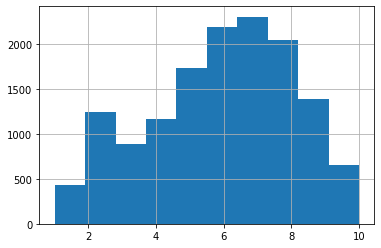

In [19]:
pd.Series(num_unique_sites).hist();

Проверим с помощью QQ-плота и критерия Шапиро-Уилка, что эта величина распределена нормально

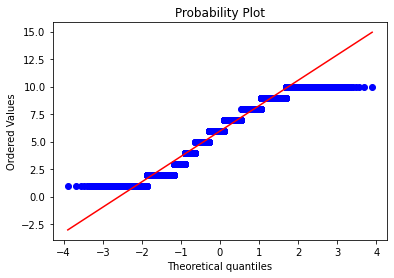

In [23]:
stats.probplot(num_unique_sites, plot=plt);

In [24]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(num_unique_sites))

Shapiro-Wilk normality test, W-statistic: 0.954693, p-value: 0.000000


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Гипотезу о нормальности распределения отвергаем.

Проверим гипотезу о том, что пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов. Давайте проверим с помощью биномиального критерия для доли, что доля случаев, когда пользователь повторно посетил какой-то сайт (то есть число уникальных сайтов в сессии < 10) велика: больше 95%.

In [25]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
has_two_similar

array([1, 1, 1, ..., 1, 1, 1])

In [26]:
# число успехов, число попыток
has_two_similar.sum(), has_two_similar.size

(13410, 14061)

In [27]:
# доля успехов
has_two_similar.sum() / has_two_similar.size

0.9537017281843396

H0: p = 0.95

H1: p > 0.95

In [28]:
pi_val = stats.binom_test(x=has_two_similar.sum(), n=has_two_similar.size, p=0.95, alternative='greater')
pi_val

0.02207653769072678

p-value меньше 0.05. Нулевую гипотезу отвергаем, вероятность повторения сайта в сессии значимо больше 95%

Построим для этой доли 95% доверительный интервал Уилсона

In [30]:
wilson_interval = proportion_confint(count=has_two_similar.sum(), nobs=has_two_similar.size, method='wilson')
wilson_interval

(0.9501028841411286, 0.9570527377232229)

Построим распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.

In [32]:
site_freqs = train_data_10users.iloc[:, :-1].apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False)

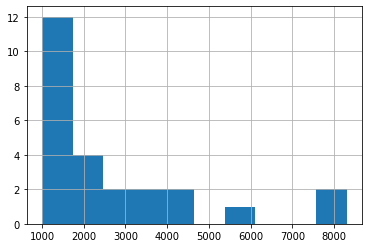

In [33]:
site_freqs[site_freqs >= 1000].hist();

Построим 95% доверительный интервал для средней частоты появления сайта в выборке на основе bootstrap. Используем столько же bootstrap-подвыборок, сколько сайтов оказалось в исходной выборке по 10 пользователям.

In [34]:
site_freqs.drop(0, inplace=True) # удаляем сайт с индексом 0

In [35]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [36]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [37]:
bootstrap_mean_scores = list(map(np.mean, get_bootstrap_samples(site_freqs.values, len(site_freqs))))
interval = stat_intervals(bootstrap_mean_scores, 0.05)

print("95% доверительный интервал для средних значений частот посещений сайтов:",  interval)

95% доверительный интервал для средних значений частот посещений сайтов: [22.51524527 35.76303684]
